# <center>Random walk, Wiener process, It&ocirc; process.<br/><br/>Black-Scholes equation. Option pricing.</center>

Today our goal will be to calculate the value of a European call option with a differential equation model. We will use the same main assumptions as in the case of the binomial tree pricer: 
* the option's underlying stock pays no dividends
* investors are insensitive to the volatility of the underlying (risk-free measure)
* any amount of the underlying can be purchased or sold at any time at zero cost

# <center>Before we start: Please do the following</center>
Refresh your knowledge by reading the following: 
1. [PDEs](https://en.wikipedia.org/wiki/Partial_differential_equation) $\, \rightarrow\, $ read Introduction, Notation, Classification, Analytical solutions by separating variables
2. Vectorization in python, [here is a compact example](https://stackoverflow.com/questions/47755442/what-is-vectorization)

## Contents

| Theory        | Task         | Todo |
| :------------ |:-------------| :------------ 
| [Standard normal distribution](#Theory_StandardNormalDistribution)<br/>[Excess kurtosis](#Theory_ExcessKurtosis) | [Plot distributions.<br/>Compare their kurtoses](#Task_PlotDistributionsCompareTheirKurtoses) | |
| [Wiener process:<br/>Continuous limiting case of a random walk](#Theory_WienerProcessDefinition) | [Plot rescaled random walk](#Task_PlotRescaledRandomWalk) | |
| [Rescaling the Wiener process](#Theory_SelfAffineFunctionValueDifference)<br/>[Generalized Wiener process](#Theory_GeneralizedWiener) | [Plot the generalized Wiener process](#Task_PlotGeneralizedWiener) | |
| [It&ocirc; process and It&ocirc;'s lemma](#Theory_ItoProcessAndLemma) | | |
| [Vectorized calculation with <tt>numpy</tt>](#Theory_VectorizationNumpy) | | [Example: Large dot product<br/>with and without vectorization](#Task_VectorizationNumpy) |
| [Black-Scholes-Merton differential equation<br/>Black-Scholes pricing formula](#Theory_BSM) | [Plot Black-Scholes pricing](#Task_PlotBlackScholesPricing) | |
| [Volatility smile](#Theory_VolatilitySmile), [Volatility Cube](#Theory_VolCube) | | |

## <a name="Theory_StandardNormalDistribution" style="text-decoration: none">Standard normal distribution</a>

- Expectation value (mean): $E$ or $\mu$
- Standard deviation: $\sigma$
- Variance: $\sigma^2$
- Volatility in financial calculations: Variance in a given time window, usually 1 year
- Note: Volatility grows as the square root of the size of the time window
  - For example: 3-month volatility is usually 1/2 of the 1-year volatility

<br/>
Probability density function (PDF) of the <b>normal distribution</b> (also called Gaussian):<br/><br/>
$$\displaystyle{p\ (x,\ \mu,\ \sigma)\ =\ \frac{1}{\sigma\ \sqrt{\ 2 \pi\ }}\  \exp \left( \frac{-\left(x-\mu\right)^{\ 2}}{2\ \sigma^{\ 2}}\right) }$$

<br/>
Set $\ \mu=0\ $ and $\ \sigma=1\ $ to get the PDF of the <b>standard normal distribution:</b><br/><br/>
$$\displaystyle{\phi\ (0\ ,1)\ = \frac{1}{\sqrt{\ 2 \pi\ }}\  \exp \left( \frac{ - x^{\ 2}}{2} \right)}$$

## <a name="Theory_ExcessKurtosis" style="text-decoration: none;">Excess Kurtosis</a>

### Kurtosis
The kurtosis is the 4th central moment of a distribution. It is the expectation value of $\displaystyle{\left(\frac{x-\mu}{\sigma}\right)^4}$


It is a measure of the "tailedness" of a distribution. In other words, it measures how "heavy" are the tails of the distribution.


The kurtosis of the standard normal distribution is 3.

### Excess kurtosis, $K$
- Here "excess" means: compared to the normal distribution
- The goal of the definition is that the excess kurtosis of the normal distribution should be zero, thus, the excess kurtosis is: $\ K =$ Kurtosis $-$ 3

Excess kurtosis of frequently used distributions:<br/>
  - [Depends](https://en.wikipedia.org/wiki/Kurtosis#Excess_kurtosis) on the distribution's parameter: [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution), [Binomial](https://en.wikipedia.org/wiki/Binomial_distribution)
  - Always zero (mesokurtic): [Normal](https://en.wikipedia.org/wiki/Normal_distribution)
  - Always positive (platykurtic): [Exponential](https://en.wikipedia.org/wiki/Exponential_distribution), [Double exponential (Laplace)](https://en.wikipedia.org/wiki/Laplace_distribution), [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution)
  - Always negative (leptokurtic): [Uniform](https://en.wikipedia.org/wiki/Uniform_distribution_&#40;continuous&#41;)


## <a name="Task_PlotDistributionsCompareTheirKurtoses" style="text-decoration: none;">Plot distributions. Compare their kurtoses.</a>

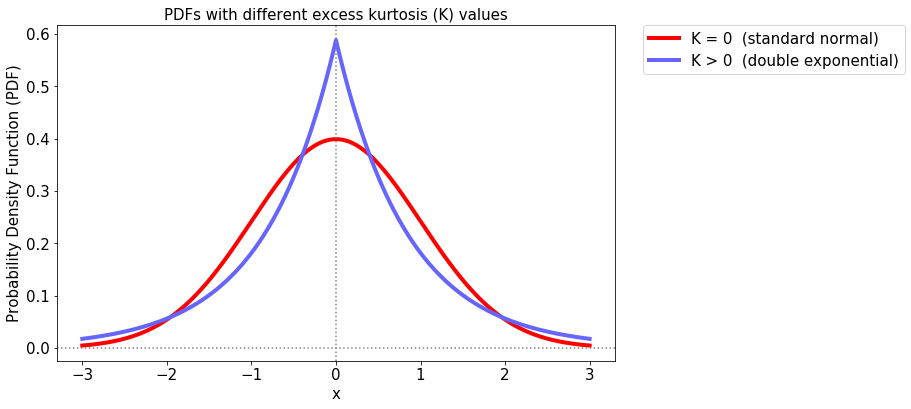

In [18]:
# === Try the following: ===
# (1) change the mean of the normal distribution
# (2) change the width of the double exponential (Laplace) distribution

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.figure(figsize=(10, 6.18)) # resizing the figure
w = 4 # line width for plotting

# === Definitions, NOTE: PDF means Probability Density Function ===
range_min, range_max, step = -3.0, 3.0, 0.001 # the end points and step size of the range for plotting PDF values
x_axis = np.arange(-range_max, range_max, step) # x (horizontal) coordinates of the points of the PDF curves
prob_dens_normal_distribution = stats.norm.pdf(x_axis, 0, 1) # compute PDF values for the normal distribution
prob_dens_double_exponential_distribution = stats.laplace.pdf(x_axis, 0, 0.85) # compute double exponential PDF values
my_fontsize = 15 # font size to be used on this plot

# === Plotting ===
plt.plot(x_axis, prob_dens_normal_distribution, color='#ff0000', label="K = 0  (standard normal)", lw=w)
plt.plot(x_axis, prob_dens_double_exponential_distribution, color='#6666ff', label="K > 0  (double exponential)", lw=w)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=my_fontsize) # legend position and font size
plt.xlabel('x', fontsize=my_fontsize) # label of the horizontal axis
plt.ylabel('Probability Density Function (PDF)', fontsize=my_fontsize) # label of the vertical axis
plt.title('PDFs with different excess kurtosis (K) values', fontsize=my_fontsize) # title of the plot
plt.tick_params(labelsize=my_fontsize) # tick label size
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.axvline(0, c='gray', ls='dotted') # vertical zero axis, dotted
plt.show(); # display the entire plot

## <a name="Theory_WienerProcessDefinition" style="text-decoration: none">Wiener process</a>
### Random walk
Consider independent and identically distributed $x_1, x_2, \dots$ random variables with mean $\mu=0$ and standard deviation $\sigma=1$. The sum of these variables from $x_1$ to $x_n$ gives the distance of the random walk from its starting point after the $n$th step:

$$S_n = \sum_{i=1}^{n}\ x_i$$

### Changing the variable from step number $n$ to time $t$ and adding the parameter $\Delta t$ (time length of step)

Set the time length of each step during this random walk to $\Delta t = 1$. With this notation the random walk becomes a function of the time, $t=n\ \Delta t$, where $\Delta t$ is a changeable parameter:

$${\displaystyle S\left(\ t,\ \Delta t\ \right) = \sum_{i=1}^{\Large{\ \frac{t}{\Delta t}\ }}\ x_i}$$


Note that this summation goes from the index  $\ i=1\ $ to the index $\ i=\Large{\frac{t}{\Delta t}\ }$.


### Normalization in the $\ \Delta t\to 0\ $ limiting case

#### <span style="color:#d00">Mathematical definition of the Wiener process</span>

In the $\Delta t\to 0$ limiting case a rescaled version of the above sum will converge to the Wiener process, $\ z\ (\ t\ )$:

$$S\left(\ t,\ \Delta t\ \right)\ \cdot\ \sqrt{\frac{\Delta t}{t} }\ \to\ z\ (\ t\ )$$

#### <span style="color:#d00">Definition of the Wiener process for computational calculations</span>

For computational calculations use the step number ($n$) and the lower integer part function (denoted by $\left\lfloor\dots\right\rfloor$ in the limit of the sum) :

$${\displaystyle{z\ (\ t\ )=\frac{1}{\sqrt{n}}\sum_{i\ =\ 1}^{\left\lfloor\ n\ t\ \right\rfloor} x_i}}$$

#### The Wiener process is a stochastic process

(1) The expression "stochastic variable" is an equivalent way of saying "random variable following a given distribution".

(2) At any given time point, $\ t\ $, the value of a stochastic process, $\ z\ (\ t\ )\ $, is not a single number, but a random variable (also called: stochastic variable).

### <a name="Task_PlotRescaledRandomWalk" style="text-decoration: none">Plot the rescaled random walk</a>

Rescaling: Different step numbers on the same time length.

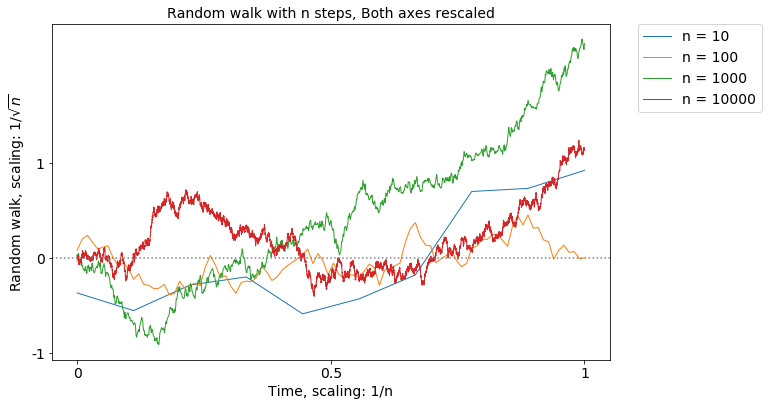

In [19]:
# === Try the following: ===
# (1) repeat several times with pow_max = 1, 2, 3, 4, 5, 6, ...
# (2) rescale with 1/n instead of 1/sqrt(n)
# (3) replace random normal steps with random 0/1 steps, use numpy.random.randint with args 2 and length

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
import random
plt.figure(figsize=(10, 6.18)) # resizing the figure
w = 1 # line width

# === Rescaled random walk ===
# The random walk is plotted with 10^1, 10^2, ... , 10^pow_max steps
# Computation starts to slow down around pow_max = 7
pow_max = 4
for n in ([int(np.power(10.0,x+1)) for x in np.arange(pow_max)]):
    # === Definitions ===
    random_steps = np.random.normal(0, 1, n) # n random steps, each selected from a std. normal distribution
    cumulated_random_steps = np.cumsum(random_steps) # cumulated sum of the random steps
    rescaled_cumulated_random_steps = [ x / np.sqrt(n) for x in cumulated_random_steps ] # rescaling cumulated sums 
    rescaled_time_points = np.linspace(0, 1, n) # the list of n time points between 0 and 1
    # === Plotting ===
    plt.plot(rescaled_time_points, rescaled_cumulated_random_steps, label="n = %d" % n, lw=w)

# === Plot properties ===
my_fontsize = 14 # font size for the text of the current plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=my_fontsize) # placing the legend
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.title('Random walk with n steps, Both axes rescaled', fontsize=my_fontsize) # title of the plot
plt.xlabel('Time, scaling: 1/n', fontsize=my_fontsize) # x axis label
plt.ylabel('Random walk, scaling: $1/\sqrt{n}$', fontsize=my_fontsize) # y axis label

# === Plot ticks ===
ax = plt.gca() # gca: get current axes, access the properties of the plot
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'], fontsize=my_fontsize)
ax.set_yticks([-1,0,1])
ax.set_yticklabels(['-1','0','1'], fontsize=my_fontsize)
plt.tick_params(labelsize=my_fontsize) # tick label size

plt.show(); # display the entire plot

## <a name="Theory_SelfAffineFunctionValueDifference" style="text-decoration: none">Change of the Wiener process during a short time interval</a>

### Self-similarity of a stochastic object

A stochastic shape is <b>self-similar</b>, if after identical rescaling in both directions, it becomes statistically indistiguishable from an identically sized part of its not yet rescaled version.

#### Example

Consider the square $\ \left[0, 1\right] \times \left[0, 1\right]\ $ and place randomly and independently a very large number ($n$) of points inside this square. Rescaling both axes of this square with the same number, for example, $\ a<1\ $, will give a smaller square that looks statistically indistinguishable from any $\ a \times a\ $ portion of the original square.


### Self-affinity of a stochastic object

A stochastic shape is <b>self-affine</b>, if it needs different rescaling in the two directions to become statistically indistiguishable from an identically sized part taken from its version before the rescaling.

#### Example

Based on the above plot and mathematical proofs: for any $\ a>0\ $ number and $\ z\ (\ t\ )\ $ Wiener process<br/>the process $\ \sqrt{a}\ \cdot\ z\ (\ t\ )\ $ and the process $\ z\ (\ a\ \cdot\ t\ )\ $ are statistically indistinguishable.

In other words, during a short $\ \Delta t\ $ period of time the change of the Wiener process is proportional to $\ \sqrt{\Delta t}\ $.

<span style="color:#d00">**$\Rightarrow\ $ During a short $\ \Delta t\ $ time interval the square of the change of the Wiener process, $\ \left(\ \Delta z\ \right)^{\ 2}\ $, is proportional to $\ \Delta t\ $.**</span>


### Hurst exponent

The Hurst exponent, $\ H\ $, is the ratio of the two exponents used for rescaling in the vertical direction ($\sqrt{a}=a^{\ 1/2}$) and the horizontal direction ($a=a^{\ 1}$).

For the Wiener process the Hurst exponent is $\ H=1\ /\ 2\ $.



## <a name="Theory_GeneralizedWiener" style="text-decoration: none">Generalized Wiener process</a>

During a very short time interval, $\ dt\ $, the Wiener process changes by $\ dz\ $. 

During the same very short $\ dt\ $ time interval the <b>generalized Wiener process</b>, $\ x\ (\ t\ )\ $, changes by

$$dx\ =\ a\ dt + b\ dz$$

In the simplest case $\ a = \mathrm{const}\ $ and $\ b = \mathrm{const} \ $.

## <a name="Task_PlotGeneralizedWiener" style="text-decoration: none">Plot the generalized Wiener process with $\ a = \mathrm{const}\ $ and $\ b = \mathrm{const}$</a>

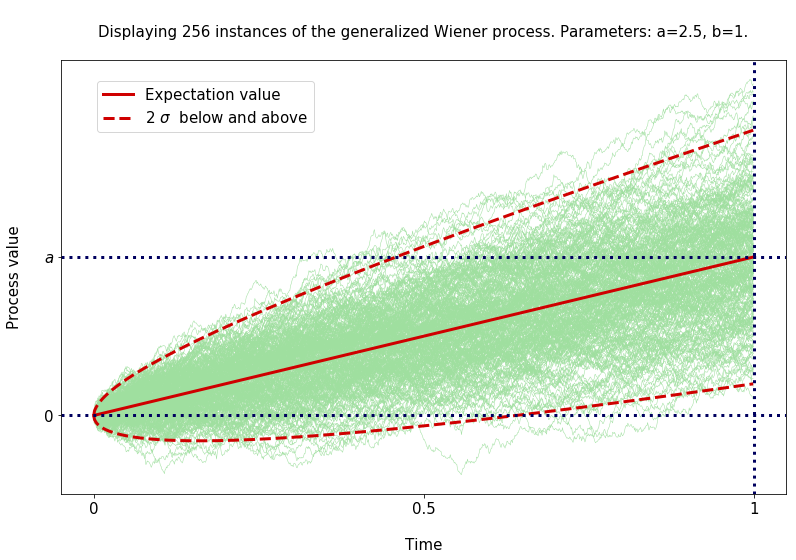

In [1]:
# === Try the following / Think about them: ===
# (1) Change the the number of instances of the random walk (nr)
# (2) At t=1 what is the average distance of the Wiener process from the straight line ?
# (3) Change the parameters a and b , but keep the a/b ratio constant. How does the process change ?
# (4) How many paths do you expect to see above the upper 2 sigma line ? How many below the lower 2 sigma line ?

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
import random

# === Definitions ===
a = 2.5 # First parameter of the generalized Wiener process
b = 1 # Second parameter
n = 1000 # number of time points for approximating the Wiener process
nr = 256 # number of instances of the Wiener process to plot

# === Settings for the Plots ===
plt.figure(figsize=(13, 8)) # resizing the figure
my_fontsize = 15
w = 3 # line width 

# === Definitions and Plotting ===
time_points = np.arange(0,1,float(1.0/n)) # previously called "rescaled_time_points", now called simply "time_points"
# Plot nr instances of the generalized Wiener process
for _ in np.arange(nr): # _ is the unnamed scalar variable, use _ if it appears only once and you don't need to name it
    # === Definitions ===
    random_steps = np.random.normal(0, 1, n) # n random steps, each selected from a std. normal distribution
    cumulated_random_steps = np.cumsum(random_steps) # cumulated sum of the random steps
    generalized_wiener_process = [ a * t + b * x/np.sqrt(n) for t, x in zip( time_points, cumulated_random_steps ) ] 
    # === Plotting ===
    plt.plot(time_points, generalized_wiener_process, color='#9fdf9f', lw=0.5)

# === Plotting baseline, labels, title, legend ===
# Note: The normal distribution has 2.1 % of its total area outside 2 sigma on each side
f = [ a * t for t in time_points ] # f(t): the straight line from [0,0] to [1,a]
f2s = [ 2.0 * b * np.sqrt(t) for t in time_points ] # f2s(t): two times the standard deviation at time t
plt.plot(time_points, f, color='#cf0000', lw=w, ls ='-', label="Expectation value") # straight line: expectation value
plt.plot(time_points, np.add(f,f2s), color='#cf0000', lw=w, ls ='--', label="$2\ \sigma\ $ below and above") # 2 sigma above
plt.plot(time_points, np.subtract(f,f2s), color='#cf0000', lw=w, ls ='--') # 2 sigma below the mean
plt.axhline(0, c='#00005f', ls=':', lw=w) # horizontal zero axis, dotted
plt.axhline(a, c='#00005f', ls=':', lw=w) # horizontal line, dotted
plt.axvline(1, c='#00005f', ls=':', lw=w) # vertical axis, dotted
plt.xlabel("\nTime", fontsize=my_fontsize) # label of the horizontal axis
plt.ylabel("Process value\n", fontsize=my_fontsize) # label of vertical axis
plt.title("\nDisplaying "+str(nr)+" instances of the generalized Wiener process. "+
          "Parameters: a="+str(a)+", b="+str(b)+".\n", fontsize=my_fontsize) # title of the plot
plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=my_fontsize) # placing the legend


# === Plotting axis ticks ===
ax = plt.gca() # gca: get current axes, access the properties of the plot
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'], fontsize=my_fontsize)
ax.set_yticks([0,a])
ax.set_yticklabels(['0',"$a$"], fontsize=my_fontsize)

# === Display the entire plot ===
plt.show()

## <a name="Theory_ItoProcessAndLemma" style="text-decoration: none">It&ocirc; process and It&ocirc;'s lemma</a>

The name refers to Kiyosi Itô, a Japanese mathematician.


### Definition of the It&ocirc; process

The It&ocirc; process is a generalized Wiener process where the coefficients $\ a\ $ and $\ b\ $ are both general functions of the elapsed time, $\ t\ $, and the current value of the process, $\ x\ \left(\ t\ \right)\ $. During a very short $\ dt\ $ time interval the change of the It&ocirc; process is

$${\displaystyle dx = a\left(x,t\right)\ dt + b\left(x,t\right)\ dz\ ,}$$

where $\ a\left(x,t\right)\ $ and $\ b\left(x,t\right)\ $ are two functions that can depend both on the time, $\ t\ $, and the current value of the process, $\ x\ $.

### Derivation of It&ocirc;'s lemma. Using the logarithm of the stock price as an example

Note: the word "lemma" means theorem. 

#### Stock price as a generalized Wiener process

If the stock price is $\ S\ \left(\ t\ \right)\ $ and its logarithm is $\ x\ \left(\ t\ \right)\ $, then $\ dx=dS\ /\ S \ $ is called the logarithmic return (relative return, rate of return).

<span style="color:#d00">**It has been observed**</span> that over short time intervals the rate of return follows a distribution that is very similar to the normal distribution. Following this observation -- and further mathematical conditions -- <span style="color:#d00">**the rate of return is modelled as an It&ocirc; process**</span>.

In the definition of the It&ocirc; process we set a constant drift and a constant volatility: $\ a\left(x,t\right)=\mu\ $ and $\ b\left(x,t\right)=\sigma\ $. With $\ dx=dS\ /\ S \ $ this gives

$$dS=\mu\ S\ dt+\sigma\ S\ dz\ ,$$

where $\ dz\ $ is the change of a Wiener process during the very short time $\ dt\ $.

#### Change of the call option's price in a short time, $\Delta t$

The price of the European call option is $\ f\ (\ S,\ t\ )\ $.

During a short time interval, $\ \Delta\ t\ $, the stock price changes by $\ \Delta\ S\ $ and the call option's price changes by $\ \Delta\ f\ $.<br/>For the option price change the Taylor expansion up to the first and second derivative terms is

$$\Delta\ f = \frac{\partial\ f}{\partial\ S}\ \Delta\ S + \frac{\partial\ f}{\partial\ t}\ \Delta\ t + \frac{1}{2}\ \frac{\partial^{\ 2}\ f}{\partial\ S^{\ 2}}\ \left(\ \Delta\ S\ \right)^{\ 2} + \frac{\partial^{\ 2}\ f}{\partial\ S\ \ \partial\ t}\ \Delta\ S\ \ \Delta\ t\  + \frac{1}{2}\ \frac{\partial^{\ 2}\ f}{\partial\ t^{\ 2}}\ \left(\ \Delta\ t\ \right)^{\ 2} \ + \ \cdots$$

#### Keeping only the linear terms $\Rightarrow$ It&ocirc;'s lemma

If the time interval $\ \Delta\ t\ $ is very short, then only those terms will be significant that are linear in $\ \Delta\ t\ $ or linear in $\ \Delta\ S\ $.

The process $\ S\ $ is also a Wiener process, thus, $\left(\ \Delta\ S\ \right)^{\ 2}$ is a linear function of $\ \Delta\ t\ $.

Therefore, we should keep the first three terms on the right hand side. All later terms are functions of $\ \Delta\ t\ $ with exponents above $1$.

Rewrite each $\ \Delta\ $ to $\ d\ $ and recall that $\ dS=\mu\ S\ dt+\sigma\ S\ dz\ .$

After replacing $\ \left(\ \Delta\ S\ \right)^{\ 2}$ with $\ \Delta\ t\ $ we obtain &nbsp; <span style="color:#d00">**It&ocirc;'s lemma**</span> &nbsp; for the change of the option's price:

$$d\ f = \left(\ \frac{\partial\ f}{\partial\ S}\ \frac{d\ S}{d\ t} + \frac{\partial\ f}{\partial\ t} + \frac{1}{2}\ \frac{\partial^{\ 2}\ f}{\partial\ S^{\ 2}} \right) \ d\ t + \frac{\partial\ f}{\partial\ S}\ \sigma\ S\ dz\ .$$

## <a name="Theory_VectorizationNumpy" style="text-decoration: none">Vectorized calculation with <tt>numpy</tt></a>

In the <tt>numpy</tt> package all mathematical operations accept arrays as inputs, and mostly produce the same shaped output.

Note: in python the term "array" (<tt>ndarray</tt>, to be more precise) is what mathematics books call a generalized matrix or tensor.

Example:

In [90]:
# Try the following:
# (1) other shapes, for example, shape = (2,5) or shape = (3,2)

import numpy as np
shape = (3)
print ("Array shape:", (shape))
print ("\nOriginal:")
a = np.random.random_sample(shape)
print(a)
print ("\nThe original numbers multiplied by 2:")
b = a * 2
print(b)
print("\nThe original numbers squared:")
print(np.square(a))

Array shape: 3

Original:
[ 0.32076034  0.6635684   0.55141093]

The original numbers multiplied by 2:
[ 0.64152069  1.3271368   1.10282187]

The original numbers squared:
[ 0.1028872   0.44032302  0.30405402]


## <a name="Task_VectorizationNumpy" style="text-decoration: none">Example: Large dot product (1) with for loop or (2) with vectorization</a>

In [2]:
# === Try the following: ===
# (1) Change the random seed and re-run the computation several times
#     What are the calculation times in the two cases ?
#     What is the ratio of the two calculation times ?
#     Does the vectorized case have always the same calculation time ?

import numpy as np
import datetime
import time
np.random.seed(9513413)

# === For loop, No vectorization ===
a = np.random.random_sample(10**6)
b = []
t1 = datetime.datetime.now()
for i in np.arange(len(a)):
    b = a[i] * a[i]
t2 = datetime.datetime.now()
dt=t2-t1
print("For loop, No vectorization: %d microseconds" % dt.microseconds)

# === Same calculation with vectorization ===
t3 = datetime.datetime.now()
c = np.square(a)
t4 = datetime.datetime.now()
dt=t4-t3
print("Same calculation with vectorization: %d microseconds" % dt.microseconds)

For loop, No vectorization: 513000 microseconds
Same calculation with vectorization: 4000 microseconds


## <a name="Theory_BSM" style="text-decoration: none">Black-Scholes-Merton differential equation and pricing</a>

### Assumptions made during the derivation of the B-S-M equation 

* Stock price follows a generalized Wiener process $\ dS=\mu\ S\ dt+\sigma\ S\ dz\ $ with constant $\ \mu\ $ and constant $\ \sigma\ $
* The risk-free rate, $\ r\ $, is constant over time and identical for all maturities.
* Any amount of money can be lent or borrowed at any time at the risk-free rate.
* Stock trading is continuous.
* Any partial amount of stock can be traded. 
* The stock pays no dividends.
* There are no transaction costs (fees, taxes, etc.).
* There are no arbitrage opportunities.

#### Arbitrage

A trading strategy that takes advantage of two or more securities being mispriced relative to each other.


### Black-Scholes-Merton differential equation

Consider a portfolio with $\ -1\ $ amount of the derivative (european call option) and ${\displaystyle{\ +\frac{\partial\ f}{\partial\ S}}}\ $ shares of the underlying stock. 

With this portfolio one can derive from It&ocirc;'s lemma (above) the &nbsp; <span style="color:#d00">**Black-Scholes-Merton differential equation**</span> &nbsp; for the price of a derivative:

$$0= -\ r\ f + \frac{\partial\ f}{\partial\ t} + r\ S\ \frac{\partial\ f}{\partial\ S} + \frac{1}{2}\ \sigma^{\ 2}\ S^{\ 2}\ \frac{\partial^{\ 2}\ f}{\partial\ S^{\ 2}} \ ,$$

where $\ r\ $ is the risk-free interest rate.


### Black-Scholes pricing formula for a European call option on a non-dividend-paying underlying stock

#### Definitions

* Risk-free rate: &nbsp; $r$
* Time to maturity of the option: &nbsp; $T$
* Current price of the underlying stock (spot price): &nbsp; $S_{\ 0}$
* Volatility of the underlying stock: &nbsp; $\sigma$
* Strike price of the option: &nbsp; $K$
* Cumulative probability distribution function of the standard normal distribution: &nbsp; $N\left(x\right)={\displaystyle\frac{1}{\sqrt{2\pi}} \int_{\normalsize{-\infty}}^{\normalsize{\ x}} dy\ \exp\left(\frac{-y^{\ 2}}{2}\right)=\frac{1}{2}\ \left[\ 1 + \mathrm{erf}\left( \frac{x}{\sqrt{2}} \right)\ \right] }\ .$
* The natural (base $\mathrm{e}$) logarithm of $\ x\ $ is &nbsp; $\log\left(\ x\ \right)$


* Definitions for the pricing: &nbsp;
   $d_{\ 1}={\displaystyle{\frac{ \log \left(\ S_{\ 0}\ /\ K\ \right) + \left(\ r+\ \sigma^{\ 2}\ /\ 2\ \right)\ T  }{\sigma\ \sqrt{T}} }}$ &nbsp;&nbsp; and &nbsp;&nbsp; $ d_{\ 2}=d_{\ 1}-\sigma\ \sqrt{T}\ . $


#### <span style="color:#d00">**Black-Scholes pricing formula**</span>

Based on the Black-Scholes-Merton differential equation, the current price of a European call option on a non-dividend-paying stock is

<span style="color:#d00">**$$c=S_{\ 0}\ N \left(\ d_{\ 1}\ \right) - K\ e^{\ -\ r\ T}\ N \left(\ d_{\ 2}\ \right)\ .$$**</span>

## <a name="Task_PlotBlackScholesPricing" style="text-decoration: none">Plot Black-Scholes pricing</a>

### Pricing function, vectorized for a range of strike price values

In [21]:
# === Importing libraries ===
import numpy as np
from scipy.special import erf

# === The pricing function ===
def black_scholes_eur_call(r,T,S0,sigma,K_vec):
    ''' Function for the Black-Scholes pricer of the risk-neutral pricing
        of a European call option on a non-dividend-paying underlying stock
        
        This function calcuates the option price for a range of strike price (K) values

    Attributes
    ==========
    r:     float  the constant risk-free short rate
    T:     float  the time to maturity given in year fractions
    S0:    float  current stock price, also called: spot price
    sigma: float  volatility of the underlying stock
    K_vec: vec float - list of strike price values for which the price should be calculated

    Note
    ====
    sigma  has to be  >  0
    r      has to be  >  0

    Output
    ======
    List of call option values, one value for each strike price. '''
    
    # --- Conversions --- 
    r     = float(r)
    T     = float(T)
    S0    = float(S0)
    sigma = float(sigma)

    # --- Checking constrains ---
    assert sigma > 0
    assert r > 0

    # --- d1 and d2 ---
    d1_vec = ( np.log( S0 / K_vec ) + ( r + 0.5 * sigma**2 ) * T ) / ( sigma * T**0.5 )
    d2_vec = d1_vec - sigma * T**0.5

    # --- N(d1) and N(d2) ---
    N_d1_vec = 0.5 * ( 1.0 + erf( d1_vec / np.sqrt(2) ) ) # N(x) = 1/2 * [ 1 + erf(x/sqrt(2)) ]
    N_d2_vec = 0.5 * ( 1.0 + erf( d2_vec / np.sqrt(2) ) )

    # --- Option price ---
    c_vec = N_d1_vec * S0 - K_vec * np.exp((-1.0)*r*T) * N_d2_vec
    
    # --- Return the computed option price values ---
    return c_vec

### Plot Black-Scholes price of the option for different maturities

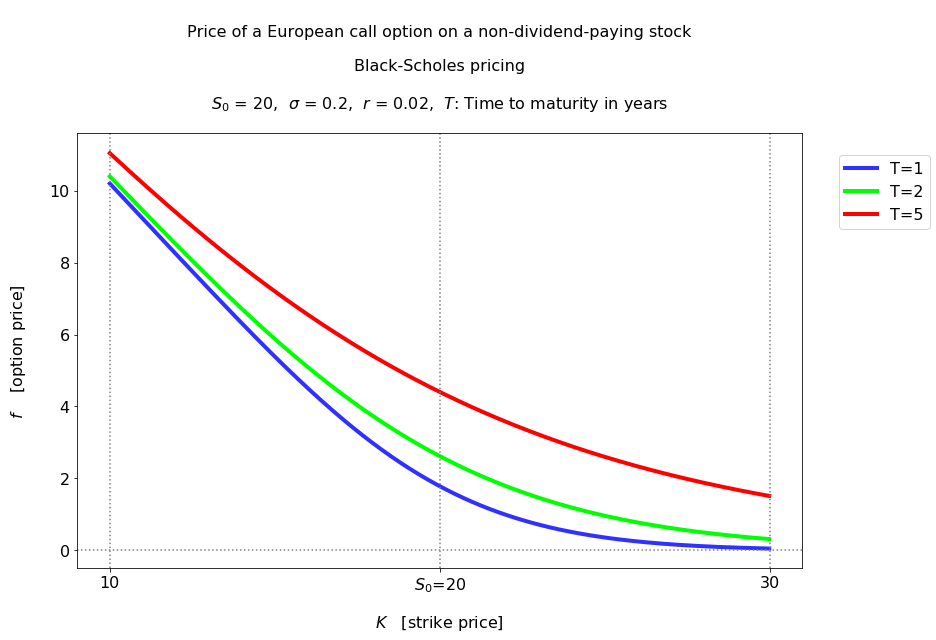

In [22]:
# === Try the following ===
# (1) Increase the number of time steps by a factor of 10, 100, 1000 and check computation time
#     in other words: reduce the step size K_step by a factor of 10, 100 or 1000

# === Import libraries ===
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
K_min = 10.0 # minimum
K_max = 30.0 # maximum
K_step = 0.01 # step size
K_vec = np.arange(K_min, K_max, K_step) # strike prices for which the option price is calculated
r = 0.02 # risk-free rate
S0 = 20.0 # spot (current price of the underlying stock)
sigma = 0.2 # yearly volatility of the underlying stock
T_vec = [1.0, 2.0, 5.0] # list of values for: time to maturity (in year fractions)
color_vec = ["#3030ff","#00ff00","#ff0000"] # colors for plotting
w = 4 # line width for plotting
S0_str = "{:.2g}".format(S0) # S0 converted to string
K_min_str = "{:.2g}".format(K_min)
K_max_str = "{:.2g}".format(K_max)
my_fontsize = 16
plt.figure(figsize=(13, 8)) # resizing the figure

# === Plotting the option price for each tree depth ===
for current_color, T in zip(color_vec, T_vec):
    # For each strike price calculate the option price
    f_vec = black_scholes_eur_call(r,T,S0,sigma,K_vec)
    # Plot the calculated option price curve
    plt.plot(K_vec, f_vec, label="T=%g" % T, color=current_color, linestyle='-', lw = w)

# === Plotting: Legend, Title, Axis label, Ticks ===
plt.legend(bbox_to_anchor=(1.05, .95), loc=2, borderaxespad=0., fontsize=my_fontsize) # legend position and font size
ax = plt.gca() # gca: get current axes, use this variable to access additional settings of the plot
ax.set_xticks([K_min,S0,K_max]) # tick positions along the horizontal axis
ax.set_xticklabels([K_min_str,"$S_0$="+S0_str,K_max_str], fontsize=my_fontsize) # tick labels 
plt.title("\nPrice of a European call option on a non-dividend-paying stock\n\n"+  # plot title
         "Black-Scholes pricing\n\n$S_0$ = %g, $\ \sigma$ = %.1g, $\ r$ = %g, $\ T$: Time to maturity in years\n" 
          % (S0, sigma, r), fontsize=my_fontsize)
plt.xlabel("\n$K\ \ $ [strike price]", fontsize=my_fontsize) # horizontal axis label
plt.ylabel("$f\ \ $  [option price]\n", fontsize=my_fontsize) # horizontal axis label
plt.tick_params(labelsize=my_fontsize) # tick text font size
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.axvline(K_min, c='gray', ls='dotted')
plt.axvline(S0, c='gray', ls='dotted')
plt.axvline(K_max, c='gray', ls='dotted')

# === Display the entire plot ===
plt.show()

### Plot Black-Scholes price of the option for different risk-free rates and volatilities

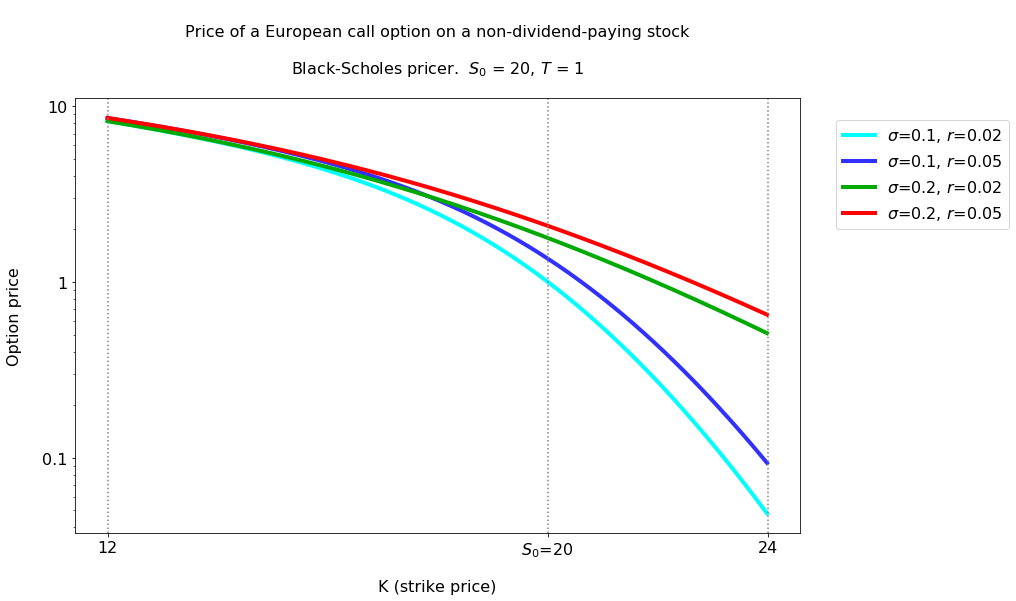

In [23]:
# === Think about the following ===
# (1) How does the price of the call option change with growing r (risk-free rate) ?
# (2) How does it change with growing sigma (volatility) ?

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.ticker import FormatStrFormatter # for the semilog plot

# === Parameters ===
S0 = 20.0 # spot (current price of the underlying stock)
K_min = S0 * 0.6 # range of the horizontal (strike price) axis
K_max = S0 * 1.2 # 
K_step = 0.01 # step size
K_vec = np.arange(K_min, K_max, K_step) # strike prices for which the option price is calculated
r_sigma_pair_vec = ((.02,.1), (.05,.1), (.02,.2), (.05,.2)) # list of pairs: risk-free rate, volatility
T = 1.0 # time to maturity of the option (in years)
color_vec = ["#00ffff","#3030ff","#00aa00","#ff0000"] # colors for plotting
w = 4 # line width for plotting
S0_str = "{:.2g}".format(S0) # S0 converted to string
K_min_str = "{:.2g}".format(K_min)
K_max_str = "{:.2g}".format(K_max)
my_fontsize = 16
plt.figure(figsize=(13, 8)) # resizing the figure

# === Plotting the option price for each tree depth ===
for current_color, (r, sigma) in zip(color_vec, r_sigma_pair_vec):
    # For each strike price calculate the option price
    f_vec = black_scholes_eur_call(r,T,S0,sigma,K_vec)
    # Plot the calculated option price curve
    plt.semilogy(K_vec, f_vec, label="$\sigma$=%g, $r$=%g" % (sigma,r), color=current_color, linestyle='-', lw = 4)

# === Plotting: Legend, Title, Axis label, Ticks ===
plt.legend(bbox_to_anchor=(1.05, .95), loc=2, borderaxespad=0., fontsize=my_fontsize) # legend position and font size
ax = plt.gca() # gca: get current axes, use this variable to access additional settings of the plot
ax.set_xticks([K_min,S0,K_max]) # tick positions along the horizontal axis
ax.set_xticklabels([K_min_str,"$S_0$="+S0_str,K_max_str], fontsize=my_fontsize) # tick labels 
plt.title("\nPrice of a European call option on a non-dividend-paying stock\n\n"+  # plot title
         "Black-Scholes pricer.  $S_0$ = %g, $T$ = %g\n" % (S0, T), fontsize=my_fontsize)
plt.xlabel('K (strike price)', fontsize=my_fontsize, labelpad=20) # horizontal axis label
plt.ylabel('Option price', fontsize=my_fontsize, labelpad=20) # horizontal axis label
plt.tick_params(labelsize=my_fontsize) # tick text font size
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.axvline(K_min, c='gray', ls='dotted')
plt.axvline(S0, c='gray', ls='dotted')
plt.axvline(K_max, c='gray', ls='dotted')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g')) # for the semilog plot

# === Display the entire plot ===
plt.show()

## <a name="Theory_VolatilitySmile" style="text-decoration: none">Volatility smile</a>

* How closely does the lognormal distribution describe the short-time changes of the price of an asset ?
* An equivalent question: How closely does the <u>normal distribution</u> describe the <u>short-time relative changes (log changes)</u> of the price of a real asset ?
  
$\rightarrow$ Note that the Black-Scholes-Merton pricing

<span style="color:#d00">**$$c=S_{\ 0}\ N \left(\ d_{\ 1}\ \right) - K\ e^{\ -\ r\ T}\ N \left(\ d_{\ 2}\ \right)\ .$$**</span>

can be used to calculate in the reverse direction. From the observed option price, $\ c\ $, <br/>
one can invert the cumulated density function, $\ N\ $, to compute the volatility, $\ \sigma\ $.<br/>
The volatility obtained this way is called __implied volatility__.

Below we compare the cumulated density functions (CDF) of two distributions with different excess kurtosis.

The first image (PDF) is the image that have already seen above.

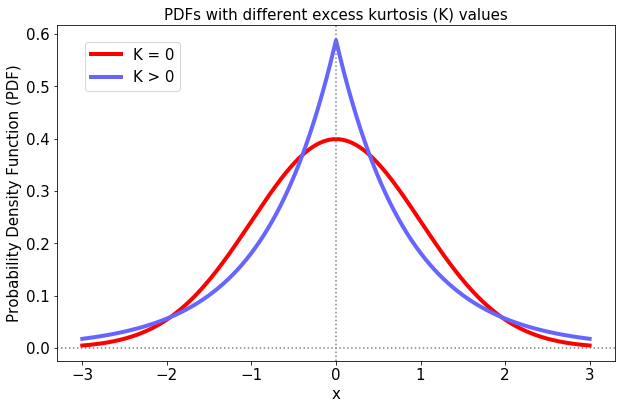

In [11]:
# === Try the following: ===
# (1) change the mean of the normal distribution
# (2) change the width of the double exponential (Laplace) distribution

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.figure(figsize=(10, 6.18)) # resizing the figure
w = 4 # line width for plotting

# === Definitions, NOTE: PDF means Probability Density Function ===
range_min, range_max, step = -3.0, 3.0, 0.001 # the end points and step size of the range for plotting PDF values
x_axis = np.arange(-range_max, range_max, step) # x (horizontal) coordinates of the points of the PDF curves
prob_dens_normal_distribution = stats.norm.pdf(x_axis, 0, 1) # compute PDF values for the normal distribution
prob_dens_double_exponential_distribution = stats.laplace.pdf(x_axis, 0, 0.85) # compute double exponential PDF values
my_fontsize = 15 # font size to be used on this plot

# === Plotting ===
plt.plot(x_axis, prob_dens_normal_distribution, color='#ff0000', label="K = 0", lw=w)
plt.plot(x_axis, prob_dens_double_exponential_distribution, color='#6666ff', label="K > 0", lw=w)
plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=my_fontsize) # legend position and font size
plt.xlabel('x', fontsize=my_fontsize) # label of the horizontal axis
plt.ylabel('Probability Density Function (PDF)', fontsize=my_fontsize) # label of the vertical axis
plt.title('PDFs with different excess kurtosis (K) values', fontsize=my_fontsize) # title of the plot
plt.tick_params(labelsize=my_fontsize) # tick label size
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.axvline(0, c='gray', ls='dotted') # vertical zero axis, dotted
plt.show(); # display the entire plot

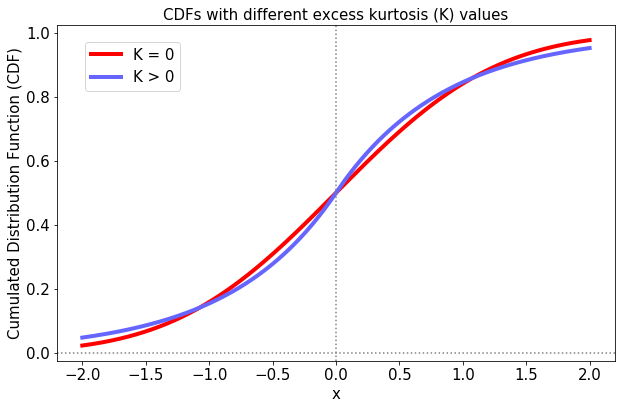

In [10]:
# === Try the following: ===
# (1) change the mean of the normal distribution
# (2) change the width of the double exponential (Laplace) distribution

# === Importing libraries ===
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.figure(figsize=(10, 6.18)) # resizing the figure
w = 4 # line width for plotting

# === Definitions ===
# === Notes: CDF means Cumulated Distribution Function ===
# ===        CDF is the integral of the PDF ===
range_min, range_max, step = -2.0, 2.0, 0.001 # the end points and step size of the range for plotting CDF values
x_axis = np.arange(-range_max, range_max, step) # x (horizontal) coordinates of the points of the CDF curves
cdf_normal_distribution = stats.norm.cdf(x_axis, 0, 1) # compute CDF values for the normal distribution
cdf_double_exponential_distribution = stats.laplace.cdf(x_axis, 0, 0.85) # compute double exponential CDF values
my_fontsize = 15 # font size to be used on this plot

# === Plotting ===
plt.plot(x_axis, cdf_normal_distribution, color='#ff0000', label="K = 0", lw=w)
plt.plot(x_axis, cdf_double_exponential_distribution, color='#6666ff', label="K > 0", lw=w)
plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0., fontsize=my_fontsize) # legend position and font size
plt.xlabel('x', fontsize=my_fontsize) # label of the horizontal axis
plt.ylabel('Cumulated Distribution Function (CDF)', fontsize=my_fontsize) # label of the vertical axis
plt.title('CDFs with different excess kurtosis (K) values', fontsize=my_fontsize) # title of the plot
plt.tick_params(labelsize=my_fontsize) # tick label size
plt.axhline(0, c='gray', ls='dotted') # horizontal zero axis, dotted
plt.axvline(0, c='gray', ls='dotted') # vertical zero axis, dotted
plt.show(); # display the entire plot

As the strike price moves away from the ATM price,<br/>
the implied volatily becomes higher.<br/>
This effect is called the __volatility smile.__

![VolConcepts](img/Vol-Concepts.png)

## <a name="Theory_VolCube" style="text-decoration: none">Volatility Cube</a>

The volatility cube contains implied volatility values calculated from market data with the following three parameters:

* Maturity of the option
* Tenor of the underlying
* Strike on the option

Based on market data, one can directly compute the implied volatilities only for frequently used maturities (1 month, 3 months, 6 months, 1 year, etc), tenors (6m, 1y, 2y, etc) and strike values (ATM, +50bp, +100bp, -50bp, -100bp, etc). All other implied volatility values of the volcube need to calculated with interpolation.